In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from xgboost import XGBRegressor
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def shuffle_dataset(df):
    df = shuffle(df)
    df.reset_index(inplace=True, drop=True)
    return df

def convert_to_label(prediction):
    """
    Convert float number to integer
    """
    prediction[prediction > 5] = 5
    prediction[prediction < 1] = 1
    prediction = np.round(prediction)
    return prediction.astype(int)

def cross_val_score(df, labels, n_splits, reg=False, reg_params=None):
    """
    Аналог кросс-валидации для моделей из statsmodels
    """
    N = len(df)
    chunk_size = N // n_splits
    val_scores = []
    train_scores = []
    idx = np.arange(N)
    for i in range(0, N, chunk_size):
        train_idx = np.hstack((idx[:i], idx[i+chunk_size:]))
        val_idx = idx[i:i+chunk_size]
        X_train, y_train = df.iloc[train_idx,:], labels[train_idx]
        X_val, y_val = df.iloc[val_idx, :], labels[val_idx]

        model = sm.OLS(y_train, X_train, missing='drop')
        if reg == True:
            if reg_params is not None:
                model = model.fit_regularized(**reg_params)
            else:
                model = model.fit_regularized()
        else:
            model = model.fit()
        
        train_pred = model.predict(X_train)
        train_pred = convert_to_label(train_pred)
        val_pred = model.predict(X_val)
        val_pred = convert_to_label(val_pred)
        
        train_scores.append(mean_absolute_error(y_train, train_pred))
        val_scores.append(mean_absolute_error(y_val, val_pred))    
    return np.array(train_scores), np.array(val_scores)

In [19]:
data = pd.read_parquet('dataset_parquet.parquet')
data = shuffle_dataset(data)
data['obj_num_diff'] = data['obj_num_diff'].abs()
data.rename(columns={'Sample': 'target'}, inplace=True)
data.head()

,mi,tp,hd,name,target,type,center_dist,vs,ari,jac,f1,obj_num_diff,feat
0,0.023460,0.057076,5016.440471,00008008_027.png,2,3,297.097485,0.255544,0.214910,0.942924,0.077861,4,1912
1,0.018463,0.044794,3402.124336,00008554_009.png,5,3,122.116747,0.884860,0.287844,0.955206,0.064814,0,122
2,0.040139,0.018757,3579.095556,00009437_008.png,5,2,49.732244,0.754302,0.555769,0.981243,0.138509,0,68
3,0.087191,0.041661,2432.544964,00011157_001.png,5,2,53.954943,0.943713,0.597793,0.958339,0.233405,0,173
4,0.032916,0.045263,3983.227335,00009437_008.png,3,3,255.285688,0.710239,0.375651,0.954737,0.086244,1,651


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 13 columns):
mi              180 non-null float64
tp              180 non-null float64
hd              180 non-null float64
name            180 non-null object
target          180 non-null int64
type            180 non-null int64
center_dist     156 non-null float64
vs              180 non-null float64
ari             180 non-null float64
jac             180 non-null float64
f1              180 non-null float64
obj_num_diff    180 non-null int64
feat            180 non-null int64
dtypes: float64(8), int64(4), object(1)
memory usage: 18.4+ KB


In [21]:
data.fillna(0, inplace=True)

In [22]:
ex_cols =  ['name', 'target', 'type']
train = data.loc[:, [col for col in data.columns if col not in ex_cols]]
target = data.loc[:, 'target']

In [23]:
train.describe()

,mi,tp,hd,center_dist,vs,ari,jac,f1,obj_num_diff,feat
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02
mean,0.056072,0.070472,2876.883405,126.446802,0.592043,0.383093,0.929528,0.125444,1.083333,2.055597e+07
std,0.060017,0.066833,1294.704864,124.988974,0.328459,0.286621,0.066833,0.103694,1.162135,5.461605e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,-0.093847,0.613308,0.000000,0.000000,4.000000e+00
25%,0.010378,0.021897,2208.364780,28.212265,0.346510,0.142300,0.892119,0.044353,0.000000,1.310000e+02
50%,0.034528,0.049914,2901.845295,97.000646,0.690379,0.378446,0.950086,0.111841,1.000000,4.480000e+02
75%,0.085037,0.107881,3695.301070,183.722305,0.886066,0.598554,0.978103,0.186550,1.000000,9.537500e+02
max,0.243432,0.386692,5758.710793,591.597067,1.000000,1.000000,1.000000,0.435205,7.000000,3.000000e+08


In [24]:
def normalize(df):
    mean_ = df.mean()
    std_ = df.std()
    return (df - mean_) / std_, mean_, std_

train_norm, mu, sd = normalize(train)

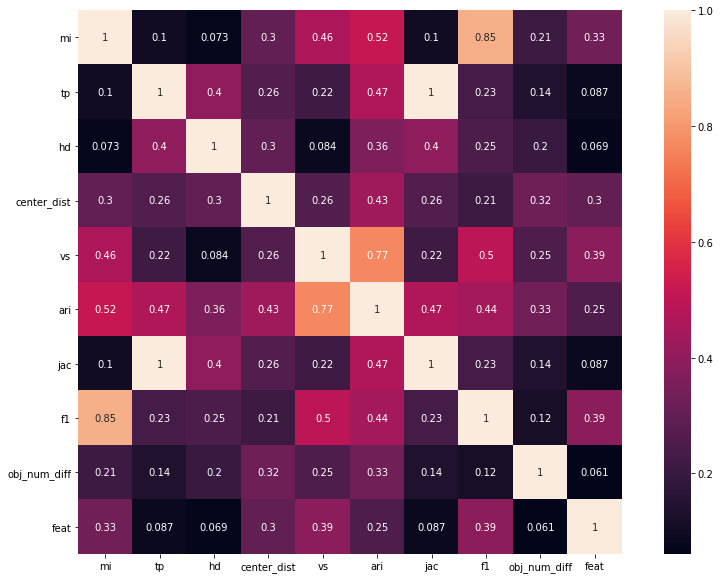

In [25]:
corr = train_norm.corr().abs()
plt.figure(figsize=(15, 10))
p = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            square=True, annot=True)
p.set_xticklabels(corr.columns.values,
                  rotation=0)
p.set_yticklabels(corr.columns.values,
                  rotation=0)
plt.show()

In [26]:
train_norm.drop('tp', axis=1, inplace=True)

# Baseline

In [27]:
const_pred = np.ones(len(train_norm)) * 3
const_mae = mean_absolute_error(const_pred, target)
print('Абсолютная ошибка константного предсказания:', np.round(const_mae, 3))

Абсолютная ошибка константного предсказания: 1.178


# Простая линейная регрессия

In [29]:
train_simple = train_norm.copy()
train_simple = sm.add_constant(train_simple)
model_simple = sm.OLS(target, train_simple, missing='drop')
model_simple = model_simple.fit()

In [30]:
model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     33.59
Date:                Sun, 01 Nov 2020   Prob (F-statistic):           2.17e-33
Time:                        01:15:02   Log-Likelihood:                -224.56
No. Observations:                 180   AIC:                             469.1
Df Residuals:                     170   BIC:                             501.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1667      0.065     49.006      0.000       3.039       3.294
mi              -0.0469      0.136     -0.345      0.731      -0.315       0.222
hd               0.0507      0.084      0.603      0.547      -0.115       0.217
center_dist     -0.3444      0.088     -3.905      0.000      -0.518      -0.170
vs              -0.0066      0.115     -0.057      0.954      -0.233       0.219
ari              1.0346      0.147      7.035      0.000       0.744       1.325
jac             -0.3613      0.089     -4.039      0.000      -0.538      -0.185
f1              -0.1231      0.149     -0.826      0.410      -0.418       0.171
obj_num_diff    -0.1452      0.071     -2.036      0.043      -0.286      -0.004
feat            -0.2840      0.085     -3.339      0.001      -0.452      -0.116
==============================================================================
Omnibus:                        4.020   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.440
Skew:                           0.150   Prob(JB):                        0.109
Kurtosis:                       3.708   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# датасет в сыром виде, все фичи сохранены, есть разница между кол-вом объектов эксерта и алгоритма
train_scores, val_scores = cross_val_score(train_simple, target, 5)
print(f'Результат на трейне: {np.round(train_scores.mean(), 3)} +/- {np.round(train_scores.std(), 3)}')
print(f'Результат на валидации: {np.round(val_scores.mean(), 3)} +/- {np.round(val_scores.std(), 3)}')

Результат на трейне: 0.599 +/- 0.019
Результат на валидации: 0.678 +/- 0.048


### Оставим только статистически значимые коэффициенты 

In [31]:
significant_cols = ['const', 'ari', 'jac', 'obj_num_diff', 'center_dist', 'feat']
train_truncated = train_norm.copy()
train_truncated = sm.add_constant(train_truncated)
train_truncated = train_truncated.loc[:, significant_cols]
train_truncated['obj_num_diff'] = train_truncated['obj_num_diff'].abs()

model_truncated = sm.OLS(target, train_truncated, missing='drop')
model_truncated = model_truncated.fit()
model_truncated.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     58.12
Date:                Sun, 01 Nov 2020   Prob (F-statistic):           2.43e-35
Time:                        01:16:29   Log-Likelihood:                -228.14
No. Observations:                 180   AIC:                             468.3
Df Residuals:                     174   BIC:                             487.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1352      0.087     35.951      0.000       2.963       3.307
ari              0.9554      0.091     10.446      0.000       0.775       1.136
jac             -0.2967      0.076     -3.888      0.000      -0.447      -0.146
obj_num_diff     0.0480      0.088      0.543      0.588      -0.126       0.222
center_dist     -0.3497      0.083     -4.195      0.000      -0.514      -0.185
feat            -0.2551      0.079     -3.245      0.001      -0.410      -0.100
==============================================================================
Omnibus:                        5.076   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                5.675
Skew:                           0.217   Prob(JB):                       0.0586
Kurtosis:                       3.754   Cond. No.                         2.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
train_scores, val_scores = cross_val_score(train_truncated, target, 5)
print(f'Результат на трейне: {np.round(train_scores.mean(), 3)} +/- {np.round(train_scores.std(), 3)}')
print(f'Результат на валидации: {np.round(val_scores.mean(), 3)} +/- {np.round(val_scores.std(), 3)}')

Результат на трейне: 0.622 +/- 0.021
Результат на валидации: 0.65 +/- 0.067


# Линейная регрессия с регуляризацией

### LASSO

In [34]:
# на изначальном датасете
reg_params = {
    'alpha':0,
    'L1_wt':1
}
train_scores, val_scores = cross_val_score(train_simple, target, 5, True, reg_params)
print(f'Результат на трейне: {np.round(train_scores.mean(), 3)} +/- {np.round(train_scores.std(), 3)}')
print(f'Результат на валидации: {np.round(val_scores.mean(), 3)} +/- {np.round(val_scores.std(), 3)}')

Результат на трейне: 0.592 +/- 0.015
Результат на валидации: 0.639 +/- 0.108


In [44]:
alpha_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

best_score = 5
best_alpha = alpha_list[0]
best_l1 = l1_list[0]

for alpha in alpha_list:
    for l1 in l1_list:
        reg_params = {
            'alpha': alpha,
            'L1_wt': l1
        }
        _, val_scores = cross_val_score(train_simple, target, 5, True, reg_params)
        if val_scores.mean() < best_score:
            best_score = val_scores.mean()
            best_alpha = alpha
            best_l1 = l1
            
print('Лучший результат:', np.round(best_score, 3))

Лучший результат: 0.639


In [43]:
# на датасете с значимыми признаками
alpha_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

best_score = 5
best_alpha = alpha_list[0]
best_l1 = l1_list[0]

for alpha in alpha_list:
    for l1 in l1_list:
        reg_params = {
            'alpha': alpha,
            'L1_wt': l1
        }
        _, val_scores = cross_val_score(train_truncated, target, 5, True, reg_params)
        if val_scores.mean() < best_score:
            best_score = val_scores.mean()
            best_alpha = alpha
            best_l1 = l1
            
print('Лучший результат:', np.round(best_score, 3))

Лучший результат: 0.65
